In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 706kB 8.1MB/s 


In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda


In [ ]:
#image_size =224
image_size =456

## download dataset


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:05<00:00, 66.0MB/s]
100% 5.76G/5.76G [02:05<00:00, 49.2MB/s]


In [ ]:
!mkdir data

In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip -d /content/data/

In [ ]:
!rm /content/cassava-leaf-disease-classification.zip

# Dataset

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(img, img_name, label):
  feature = {
      'image': _int64_feature(img),
      'image_name': _bytes_feature(img_name),
      'target': _bytes_feature(label)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

total_each = 1426
save_path = '/content/drive/MyDrive/deep_fatemizade/project/gan/tfrecords'
path_gan = '/content/data/train_images/'
num = 0
for i in range(5):
  with tf.io.TFRecordWriter(os.path.join(save_path, 'GAN-data%.2i.tfrec'%(i))) as writer:
    for j in range(0, total_each):
      if j < len(df):
        idx = np.random.randint(len(df), size = 1)[0]
        img = cv2.imread(os.path.join(path_gan, df.iloc[idx]['image_id']))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
        img = cv2.resize(img, (256,256))
        img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
        name = str(idx//10)
        target = df.iloc[idx]['label']
        example = serialize_example(img, str.encode(name),target)
        writer.write(example)

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(data, target):
  feature = {
      'data': _bytes_feature(data),
      'target': _float_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()




In [ ]:
from matplotlib.image import imread
from matplotlib import pyplot as plt
import pandas as pd
import os

In [ ]:
data = pd.read_csv('/content/data/train.csv')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


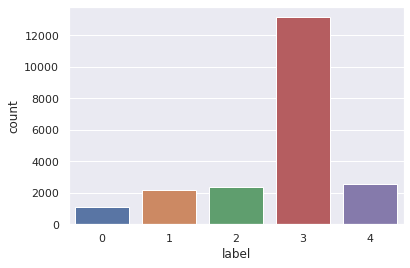

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=data)

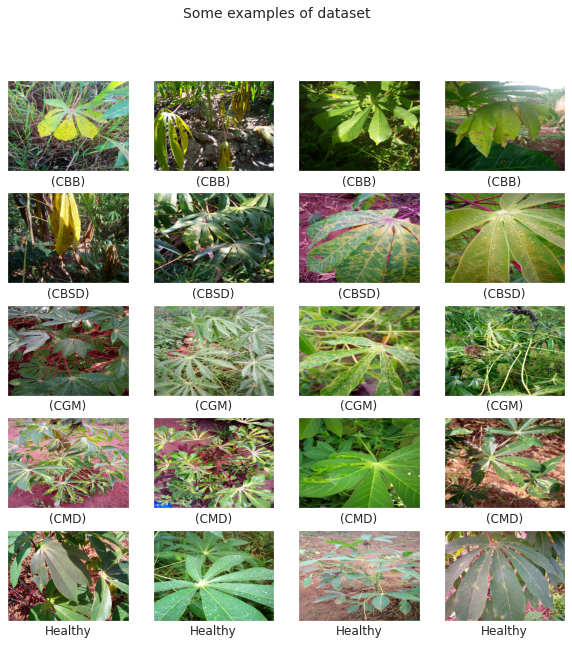

In [ ]:
int2label1 = {0: "Cassava Bacterial Blight (CBB)",
             1: "Cassava Brown Streak Disease (CBSD)",
             2: "Cassava Green Mottle (CGM)",
             3: "Cassava Mosaic Disease (CMD)",
             4: "Healthy"}
int2label = {0: "(CBB)",
             1: "(CBSD)",
             2: "(CGM)",
             3: "(CMD)",
             4: "Healthy"}


def display_dataset(path_to_csv = '/content/data/train_images/',
                    images_dir = '/content/data/train_images/'):
  images_list = pd.read_csv(path_to_csv)

  fig = plt.figure(figsize=(10,10))
  fig.suptitle("Some examples of dataset", fontsize=14)
  for j in range(5):
    class_list = images_list[images_list['label'] == j]
    class_list = class_list.reset_index()
    image_name = class_list['image_id']
    idx = np.random.randint(len(class_list), size=4)
    for i in range(4):
      plt.subplot(5,4,j*4 + i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img_path = os.path.join(images_dir, image_name[idx[i]])
      img = imread(img_path)
      plt.imshow(img)
      plt.xlabel(int2label[j])
  plt.show()

display_dataset(path_to_csv = '/content/data/train.csv',
                images_dir = '/content/data/train_images/')

## Generator

In [ ]:
def cutout(image, pad_size, replace=0):
  """Apply cutout (https://arxiv.org/abs/1708.04552) to image.

  This operation applies a (2*pad_size x 2*pad_size) mask of zeros to
  a random location within `img`. The pixel values filled in will be of the
  value `replace`. The located where the mask will be applied is randomly
  chosen uniformly over the whole image.

  Args:
    image: An image Tensor of type uint8.
    pad_size: Specifies how big the zero mask that will be generated is that
      is applied to the image. The mask will be of size
      (2*pad_size x 2*pad_size).
    replace: What pixel value to fill in the image in the area that has
      the cutout mask applied to it.

  Returns:
    An image Tensor that is of type uint8.
  """
  image_height = tf.shape(image)[0]
  image_width = tf.shape(image)[1]

  # Sample the center location in the image where the zero mask will be applied.
  cutout_center_height = tf.random.uniform(
      shape=[], minval=0, maxval=image_height,
      dtype=tf.int32)

  cutout_center_width = tf.random.uniform(
      shape=[], minval=0, maxval=image_width,
      dtype=tf.int32)

  lower_pad = tf.maximum(0, cutout_center_height - pad_size)
  upper_pad = tf.maximum(0, image_height - cutout_center_height - pad_size)
  left_pad = tf.maximum(0, cutout_center_width - pad_size)
  right_pad = tf.maximum(0, image_width - cutout_center_width - pad_size)

  cutout_shape = [image_height - (lower_pad + upper_pad),
                  image_width - (left_pad + right_pad)]
  padding_dims = [[lower_pad, upper_pad], [left_pad, right_pad]]
  mask = tf.pad(
      tf.zeros(cutout_shape, dtype=image.dtype),
      padding_dims, constant_values=1)
  mask = tf.expand_dims(mask, -1)
  mask = tf.tile(mask, [1, 1, 3])
  image = tf.where(
      tf.equal(mask, 0),
      tf.ones_like(image, dtype=image.dtype) * replace,
      image)
  return image


def solarize(image, threshold=128):
  # For each pixel in the image, select the pixel
  # if the value is less than the threshold.
  # Otherwise, subtract 255 from the pixel.
  return tf.where(image < threshold, image, 255 - image)

def solarize_add(image, addition=0, threshold=128):
  # For each pixel in the image less than threshold
  # we add 'addition' amount to it and then clip the
  # pixel value to be between 0 and 255. The value
  # of 'addition' is between -128 and 128.
  added_image = tf.cast(image, tf.int64) + addition
  added_image = tf.cast(tf.clip_by_value(added_image, 0, 255), tf.uint8)
  return tf.where(image < threshold, added_image, image)


def color(image, factor):
  """Equivalent of PIL Color."""
  degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
  return blend(degenerate, image, factor)


def contrast(image, factor):
  """Equivalent of PIL Contrast."""
  degenerate = tf.image.rgb_to_grayscale(image)
  # Cast before calling tf.histogram.
  degenerate = tf.cast(degenerate, tf.int32)

  # Compute the grayscale histogram, then compute the mean pixel value,
  # and create a constant image size of that value.  Use that as the
  # blending degenerate target of the original image.
  hist = tf.histogram_fixed_width(degenerate, [0, 255], nbins=256)
  mean = tf.reduce_sum(tf.cast(hist, tf.float32)) / 256.0
  degenerate = tf.ones_like(degenerate, dtype=tf.float32) * mean
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.image.grayscale_to_rgb(tf.cast(degenerate, tf.uint8))
  return blend(degenerate, image, factor)


def brightness(image, factor):
  """Equivalent of PIL Brightness."""
  degenerate = tf.zeros_like(image)
  return blend(degenerate, image, factor)


def posterize(image, bits):
  """Equivalent of PIL Posterize."""
  shift = 8 - bits
  return tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)

def autocontrast(image):
  """Implements Autocontrast function from PIL using TF ops.

  Args:
    image: A 3D uint8 tensor.

  Returns:
    The image after it has had autocontrast applied to it and will be of type
    uint8.
  """

  def scale_channel(image):
    """Scale the 2D image using the autocontrast rule."""
    # A possibly cheaper version can be done using cumsum/unique_with_counts
    # over the histogram values, rather than iterating over the entire image.
    # to compute mins and maxes.
    lo = tf.to_float(tf.reduce_min(image))
    hi = tf.to_float(tf.reduce_max(image))

    # Scale the image, making the lowest value 0 and the highest value 255.
    def scale_values(im):
      scale = 255.0 / (hi - lo)
      offset = -lo * scale
      im = tf.to_float(im) * scale + offset
      im = tf.clip_by_value(im, 0.0, 255.0)
      return tf.cast(im, tf.uint8)

    result = tf.cond(hi > lo, lambda: scale_values(image), lambda: image)
    return result

  # Assumes RGB for now.  Scales each channel independently
  # and then stacks the result.
  s1 = scale_channel(image[:, :, 0])
  s2 = scale_channel(image[:, :, 1])
  s3 = scale_channel(image[:, :, 2])
  image = tf.stack([s1, s2, s3], 2)
  return image


def sharpness(image, factor):
  """Implements Sharpness function from PIL using TF ops."""
  orig_image = image
  image = tf.cast(image, tf.float32)
  # Make image 4D for conv operation.
  image = tf.expand_dims(image, 0)
  # SMOOTH PIL Kernel.
  kernel = tf.constant(
      [[1, 1, 1], [1, 5, 1], [1, 1, 1]], dtype=tf.float32,
      shape=[3, 3, 1, 1]) / 13.
  # Tile across channel dimension.
  kernel = tf.tile(kernel, [1, 1, 3, 1])
  strides = [1, 1, 1, 1]
  degenerate = tf.nn.depthwise_conv2d(
      image, kernel, strides, padding='VALID')
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.squeeze(tf.cast(degenerate, tf.uint8), [0])

  # For the borders of the resulting image, fill in the values of the
  # original image.
  mask = tf.ones_like(degenerate)
  padded_mask = tf.pad(mask, [[1, 1], [1, 1], [0, 0]])
  padded_degenerate = tf.pad(degenerate, [[1, 1], [1, 1], [0, 0]])
  result = tf.where(tf.equal(padded_mask, 1), padded_degenerate, orig_image)

  # Blend the final result.
  return blend(result, orig_image, factor)


def equalize(image):
  """Implements Equalize function from PIL using TF ops."""
  def scale_channel(im, c):
    """Scale the data in the channel to implement equalize."""
    im = tf.cast(im[:, :, c], tf.int32)
    # Compute the histogram of the image channel.
    histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

    # For the purposes of computing the step, filter out the nonzeros.
    nonzero = tf.where(tf.not_equal(histo, 0))
    nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
    step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

    def build_lut(histo, step):
      # Compute the cumulative sum, shifting by step // 2
      # and then normalization by step.
      lut = (tf.cumsum(histo) + (step // 2)) // step
      # Shift lut, prepending with 0.
      lut = tf.concat([[0], lut[:-1]], 0)
      # Clip the counts to be in range.  This is done
      # in the C code for image.point.
      return tf.clip_by_value(lut, 0, 255)

    # If step is zero, return the original image.  Otherwise, build
    # lut from the full histogram and step and then index from it.
    result = tf.cond(tf.equal(step, 0),
                     lambda: im,
                     lambda: tf.gather(build_lut(histo, step), im))

    return tf.cast(result, tf.uint8)

  # Assumes RGB for now.  Scales each channel independently
  # and then stacks the result.
  s1 = scale_channel(image, 0)
  s2 = scale_channel(image, 1)
  s3 = scale_channel(image, 2)
  image = tf.stack([s1, s2, s3], 2)
  return image
def gaussian_noise_layer(image, std = 0.8):
    noise = tf.random.normal(shape= image.shape, mean=0.0, stddev=std, dtype=tf.float32)
    return image + noise



In [ ]:
# Create a dictionary describing the features.
image_feature_description = {

    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'target': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def preprocess(features,effesionet=True):
  image_raw = features['image']
  image = tf.io.decode_image(image_raw,channels=3)
  image.set_shape([image_size,image_size,3])
  label = features['target']

  return image, label


def normalize(image ,label):
  image =  tf.cast(image,tf.uint8)
  image = tf.cast(image,tf.float32)/255.0
  scale = tf.constant([0.229, 0.224, 0.225])
  offset = tf.constant([0.485, 0.456, 0.406])
  image -= offset
  image /= scale

  return image , label
@tf.function
def central_crop_fn(image, fraction):
    return tf.image.central_crop(image, fraction)


@tf.function
def agment(image,label):
  image = tf.cast(image, dtype= tf.float32)
  image = tf.image.resize(image,(image_size,image_size))
  image.set_shape([image_size,image_size,3])

  #print('image shape', image.shape)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  #print(image)
  if tf.random.uniform((),0,1.)<0.5:
    for i in range(3 + np.random.randint(10, size=1)[0]):
      image = cutout(image, 20, replace=0)
  if tf.random.uniform((),0,1.)<0.5:
    #print(image)
    image = tfa.image.rotate(image,np.random.uniform(0,1,1)[0]*360)
    #print('rotate shape', image.shape)
    #print(image)
  if tf.random.uniform((),0,1.)<0.5:
    #print(image)
    image = tfa.image.shear_y( image, np.random.uniform(0,0.3,1)[0], 0.)
    #print(image)
    image = tfa.image.shear_x( image, np.random.uniform(0,0.3,1)[0], 0.)
    #print(image)
    #print('shear shape', image.shape)
  #if tf.random.uniform((),0,1.)<0.5:
    #image = gaussian_noise_layer(image, std = np.random.uniform(0,0.5,1)[0])
    #print('gaussian shape', image.shape)
  if tf.random.uniform((),0,1.)<0.5:
    image = equalize(image)
    image = tf.cast(image, dtype= tf.float32)
  if tf.random.uniform((),0,1.)<0.5:
    h = np.random.randint(image_size//3, size=1)[0]+10
    h = h//2 # 10%
    w = np.random.randint(image_size//3, size=1)[0]+10
    w = w//2 # 10%
    cropped_image = image[h:image_size - h, w:image_size - w,:]
    image = tf.pad(cropped_image, [[h,h], [w,w], [0,0]])
    image = tf.image.resize(image,(image_size,image_size))
  if tf.random.uniform((),0,1.)<0.5:
    image = tf.image.random_brightness(image, np.random.uniform(0,1,1)[0])
  if tf.random.uniform((),0,1.) >= 0.4:
        image = tf.image.random_saturation(image, lower = 0.7, upper = 1.3)
  if tf.random.uniform((),0,1.) >= 0.4:
      image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
  '''
  if tf.random.uniform((),0,1.)<0.5:
    image = solarize(image)
  '''
  #print(image)
  return image , label

def Resize(image,label):
  image = tf.image.resize(image,(image_size,image_size))
  image.set_shape([image_size,image_size,3])
  label_one_hot = tf.one_hot(label, depth=5, on_value=1, off_value=0)
  #label_one_hot = tf.where(tf.equal(label_one_hot,1),tf.ones_like(label_one_hot),tf.ones_like(label_one_hot)*(-1))
  return image , label_one_hot


In [ ]:
BATCH_SIZE = 8
ds_train = tf.data.TFRecordDataset(['/content/data/train_tfrecords/ld_train00-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train01-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train02-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train03-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train04-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train05-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train06-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train07-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train08-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train09-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train11-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train12-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train15-1327.tfrec',
                                    '/content/data/train_tfrecords/ld_train14-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train10-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train13-1338.tfrec'])
ds_train = ds_train.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
ds_train  =  ds_train.map(preprocess).map(agment).map(normalize)
ds_train  = ds_train.map(Resize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
BATCH_SIZE_TEST = 8
ds_val = tf.data.TFRecordDataset(['/content/data/train_tfrecords/ld_train02-1338.tfrec',
                                  '/content/data/train_tfrecords/ld_train14-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train04-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train10-1338.tfrec'])
ds_val = ds_val.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(100)
ds_val  =  ds_val.map(preprocess).map(normalize)
ds_val  = ds_val.map(Resize).batch(BATCH_SIZE_TEST,drop_remainder=True).repeat()

In [ ]:
img, label = next(iter(ds_train))
img.shape

TensorShape([8, 456, 456, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


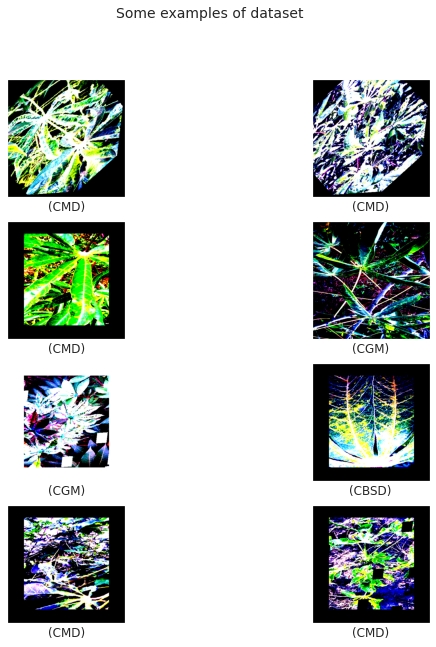

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of dataset", fontsize=14)
for j in range(4):
  for i in range(2):
    plt.subplot(4,2,j*2 + i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = img[j*2 + i].numpy()
    plt.imshow(image)
    plt.xlabel(int2label[np.argmax(label[j*2 + i])])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


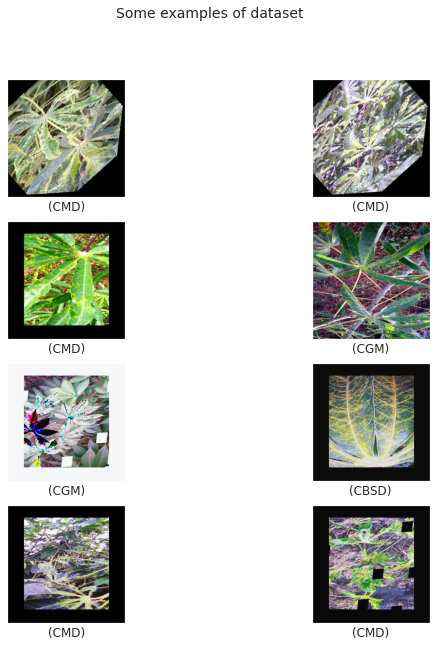

In [ ]:
scale = np.array([0.229, 0.224, 0.225])
offset =  np.array([0.485, 0.456, 0.406])

fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of dataset", fontsize=14)
for j in range(4):
  for i in range(2):
    plt.subplot(4,2,j*2 + i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = img[j*2 + i].numpy()
    image *= scale
    image += offset
    plt.imshow(image)
    plt.xlabel(int2label[np.argmax(label[j*2 + i])])
plt.show()

In [ ]:
BATCH_SIZE_TEST_count = 16
ds_val_count = tf.data.TFRecordDataset(['/content/data/train_tfrecords/ld_train02-1338.tfrec',
                                  '/content/data/train_tfrecords/ld_train14-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train04-1338.tfrec',
                                    '/content/data/train_tfrecords/ld_train10-1338.tfrec'])
ds_val_count = ds_val_count.map(_parse_image_function,num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(100)
ds_val_count  =  ds_val_count.map(preprocess).map(normalize)
ds_val_count  = ds_val_count.map(Resize).batch(BATCH_SIZE_TEST_count,drop_remainder=True)

val_steps=0
for i in ds_val_count:
  val_steps+=1
print(val_steps)
del ds_val_count

334


In [ ]:
num_val_samples = val_steps*BATCH_SIZE_TEST_count
num_val_samples

5344

In [ ]:
import pandas as pd
data = pd.read_csv('/content/data/train.csv')

In [ ]:
num_train_samples =len(data)
print(num_train_samples)

21397


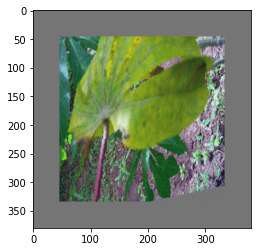

In [ ]:
plt.imshow(image)

In [ ]:
NUM_CLASSES = 5
EPOCHS = 40
TRAIN_STEPS = num_train_samples//BATCH_SIZE + 1
TRAIN_STEPS

2675

In [ ]:
VAL_STEPS = num_val_samples//BATCH_SIZE_TEST + 1
VAL_STEPS

669

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
def inspectionV2():
  # create the base pre-trained model

  base_model =  InceptionResNetV2(include_top=False, weights='imagenet',input_shape = (image_size, image_size, 3))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(BatchNormalization(axis=-1))
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])

  return model

In [ ]:
model = inspectionV2()

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
def EfficientNetB4_model():
  # create the base pre-trained model
  base_model =  EfficientNetB5(include_top=False, weights = 'imagenet', input_shape = (image_size, image_size, 3))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(BatchNormalization(axis=-1))
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  #lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-6,1000 ,decay_rate=0.96)
  optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
  for layer in base_model.layers:
    layer.trainable = True
  model.compile(loss= cce_with_label_smoothing,
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
def cce_with_label_smoothing(y_true,y_pred):
  return tf.keras.losses.categorical_crossentropy(y_true,y_pred,label_smoothing=0.2)

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
def EfficientNetB5_model():
  # create the base pre-trained model
  base_model =  EfficientNetB5(include_top=False, weights = 'imagenet', input_shape = (image_size, image_size, 3))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(BatchNormalization(axis=-1))
  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  #lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-4,1000 ,decay_rate=0.96)
  optimizer = tf.keras.optimizers.Adam(1e-5,beta_1=0.9,beta_2=0.999)

  for layer in base_model.layers:
    layer.trainable = True
  model.compile(loss= cce_with_label_smoothing,
                optimizer = optimizer,
                metrics=['accuracy'])

  return model

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
def EfficientNetB5_model():
  # create the base pre-trained model
  base_model =  EfficientNetB5(include_top=False, weights = 'imagenet', input_shape = (image_size, image_size, 3))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(BatchNormalization(axis=-1))
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-6,1000 ,decay_rate=0.96)
  optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
  for layer in base_model.layers:
    layer.trainable = True
  model.compile(loss= cce_with_label_smoothing,
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
model = EfficientNetB5_model()

115269632/115263384 [==============================] - 1s 0us/step


In [ ]:
#this is used for the first eff model
model.load_weights(
    '/content/drive/MyDrive/deep_fatemizade/project/efficientNetB5_30/weights-improvement-run1-04-0.8786.hdf5')

In [ ]:
def cce_with_label_smoothing(y_true,y_pred):
  return tf.keras.losses.categorical_crossentropy(y_true,y_pred,label_smoothing=0.2)

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
def DenseNet201_model():
  # create the base pre-trained model
  base_model =  DenseNet201(include_top=False, weights = 'imagenet', input_shape = (image_size, image_size, 3))

  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(BatchNormalization(axis=-1))
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='softmax'))
  #optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  #lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-6,1000 ,decay_rate=0.96)
  optimizer = tf.keras.optimizers.Adam(1e-5,beta_1=0.9,beta_2=0.999)
  for layer in base_model.layers:
    layer.trainable = True
  model.compile(loss= cce_with_label_smoothing,
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
model = DenseNet201_model()

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
model.load_weights('/content/drive/MyDrive/deep_fatemizade/project/Densenet201/weights-improvement-run3-28-0.8460.hdf5')

# training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/deep_fatemizade/project/efficientnetB5-class5/weights-improvement-run1-{epoch:02d}-{loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [ checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,) ]
callbacks_list = [ checkpoint]
history = model.fit(ds_train,
                    epochs= EPOCHS,
                    steps_per_epoch= TRAIN_STEPS)

Epoch 1/40
2675/2675 [==============================] - 3047s 1s/step - loss: 1.5938 - accuracy: 0.2788
Epoch 2/40
2675/2675 [==============================] - 3028s 1s/step - loss: 1.4505 - accuracy: 0.5009
Epoch 3/40
2675/2675 [==============================] - 3028s 1s/step - loss: 1.3493 - accuracy: 0.5932
Epoch 4/40
2675/2675 [==============================] - 3024s 1s/step - loss: 1.2837 - accuracy: 0.6362
Epoch 5/40
2675/2675 [==============================] - 3023s 1s/step - loss: 1.2335 - accuracy: 0.6707
Epoch 6/40
2675/2675 [==============================] - 3046s 1s/step - loss: 1.2071 - accuracy: 0.6895
Epoch 7/40
2675/2675 [==============================] - 3042s 1s/step - loss: 1.1866 - accuracy: 0.6997
Epoch 8/40
2675/2675 [==============================] - 3021s 1s/step - loss: 1.1673 - accuracy: 0.7064
Epoch 9/40
2675/2675 [==============================] - 3026s 1s/step - loss: 1.1545 - accuracy: 0.7190
Epoch 10/40
2675/2675 [==============================] - 3032s 1

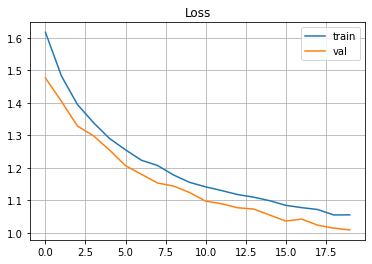

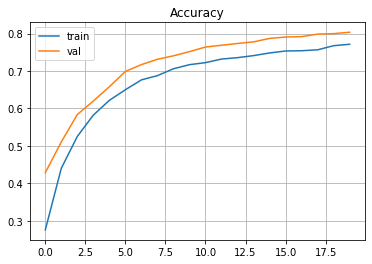

In [ ]:
# plot loss
plt.plot( history.history['loss'],'',  history.history['val_loss'],'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.show()
# plot accuracy
plt.plot(history.history['accuracy'],'', history.history['val_accuracy'],'-')
plt.title('Accuracy')
plt.legend(['train','val'])
plt.grid()
plt.show()

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint
def Vgg16():
  # create the base pre-trained model
  base_model = VGG16(weights='imagenet', include_top=False)

  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  # let's add a fully-connected layer
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.15)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.1)(x)
  # and a logistic layer
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
      layer.trainable = True

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
NUM_CLASSES =5

input_tensor = tf.keras.layers.Input(shape=(image_size, image_size, 3))
#base_model=tf.keras.applications.EfficientNetB0(include_top=False,weights="imagenet",input_tensor=input_tensor,pooling=None)
base_model=tf.keras.applications.EfficientNetB4(include_top=False,weights="imagenet",input_tensor=input_tensor,pooling=None)

#for layer in base_model.layers:
#  layer.trainable = True
x = base_model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
x =  tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions =  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
base_model.trainable =True

#model.summary()

71688192/71686520 [==============================] - 0s 0us/step


In [ ]:
num_val=4003

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(ds_train,epochs=25,validation_data=ds_val,steps_per_epoch=1000)

In [ ]:
num_val=4003
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-6),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(ds_train,epochs=25,validation_data=ds_val,steps_per_epoch=2000)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-5)

In [ ]:
def train_op(data):
  images, targets = data
  with tf.GradientTape() as tape:
    outputs = model(images, training=True)
    loss = loss_fn(outputs, targets)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  acc = accuracy_fn(outputs, targets)
  return loss, acc

In [ ]:
import tqdm

EPOCHS= 1

for epoch in range(EPOCHS):
  mean_loss = 0
  mean_acc =0
  for data in  ds_train:
    loss, acc = train_op(data)
    print(loss)


In [ ]:
model.save("/drive/MyDrive/deep_fatemizade/project/test3_rmsprop_kaggle.h5")

In [ ]:
Model=tf.keras.models.load_model('/drive/MyDrive/deep_fatemizade/project/myfirst_h5_model.h5')


In [ ]:
import glob
image_list =glob.glob('train_images/*.jpg')
print(image_list)
for dir_image in image_list:
  image = cv2.imread(dir_image)


In [ ]:
import os
import cv2
dirs = os.listdir( 'train_images' )
df = pd.DataFrame(columns=['image_id','label'])
i+=1
# This would print all the files and directories
for file_name in dirs:

  image = cv2.imread('train_images/'+str(file_name))
  #print(type(image))
  image.resize((1,image_size,image_size,3))

  prediction =Model.predict(image)

  labels=prediction.argmax()
  print(labels)
  df = df.append({'image_id': file_name,'label':labels}, ignore_index=True)


df.to_csv('submition.csv',index=False)

In [ ]:
df = pd.DataFrame(columns=['image_id','label'])
for i in range(5):
    df = df.append({'image_id': '00000hggfc.jpg','label':i}, ignore_index=True)

df.to_csv('submition.csv',index=False)
